In [2]:
import os
import sys
import pandas as pd
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import shapiro, chi2
from sklearn.linear_model import LinearRegression

ROOTDIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
REPORTDIR = os.path.join(ROOTDIR, "report")
DATADIR = os.path.join(ROOTDIR, "data")
sys.path.insert(0, ROOTDIR)


In [9]:
import glob
from src.data import process

batch = [pd.read_csv(frame) for frame in glob.glob(os.path.join(DATADIR, "exp-distribution-change-*-50.csv"))]
data = pd.concat(batch)
data.shape

(12000, 26)

In [10]:
# preprocessing the data prior to analysis
# 1. fairness metrics are only calculated when privileged == None
# 2. scale fairness metrics according to zhang2021ignorance paper
# 3. combine dataset_label & protected
# 4. set the index to iteration
# 4. drop unused columns
# 4. rename column names
# 4. rename model names
data = data[data["privileged"] == "None"]
process(data)
data["dataset_label"] = data["dataset_label"] + "-" + data["protected"].str.lower()
data = data.rename(columns={
    "dataset_label": "dataset",
    "disparate_impact": "DI",
    "statistical_parity_difference": "SPD",
})
data = data.set_index("iteration")
data = data[[
    "DI",
    "SPD",
    "model",
    "dataset",
    "change",
]]
data.loc[(data["model"] == "logisticregression"), "model"] = "LR"
data.loc[(data["model"] == "randomforestclassifier"), "model"] = "RF"
data.loc[(data["model"] == "adaboostclassifier"), "model"] = "ADA"
data.loc[(data["model"] == "decisiontreeclassifier"), "model"] = "DT"

data.shape

(4000, 5)

In [8]:
data.dtypes

DI         float64
SPD        float64
model       object
dataset     object
change      object
dtype: object

# Data Validation

In [13]:
# in this cell I am doing some manual checks to make
# sure I am sampling the data correctly by checking
# the shape of the dataset

# each vector should contain num_features*50 points

# order datasets by number of examples
datasets = ["german-age", "german-sex", "compas-race", "compas-sex", "meps-race", "bank-age", "adult-race", "adult-sex"]
models = data["model"].unique().tolist()
models.remove("None")

for dataset in datasets:
    _ = data[
        (data["dataset"] == dataset) &
        (data["model"] == "None")
    ]
    assert _[(_["change"].notna())].shape[0] == 50
    assert _[(_["change"].isna())].shape[0] == 50
    # assert _.shape[0] == len(_["frac"].unique().tolist())*50


    for model in models:
        _ = data[
            (data["dataset"] == dataset) &
            (data["model"] == model)
        ]
        assert _[(_["change"].notna())].shape[0] == 50
        assert _[(_["change"].isna())].shape[0] == 50

# Correlation

In [17]:
from scipy.stats import spearmanr

indices = [[
    "DI",
    "SPD",
],
models]
corr = pd.DataFrame(columns=datasets, index=pd.MultiIndex.from_product(
    indices, names=["metric", "model"]
))
corr_pvalues = pd.DataFrame(columns=datasets, index=pd.MultiIndex.from_product(
    indices, names=["metric", "model"]
))

for d in datasets:
    _ = data[
        (data["dataset"] == d) &
        (data["change"].isna())
    ]
    for metric in ["DI", "SPD"]:
        pivoted = pd.pivot(
            data=_,
            columns="model",
            values=metric,
        )
        for model in models:
            c, p = spearmanr(pivoted[model], pivoted["None"])
            corr.loc[(metric, model), d] = c
            corr_pvalues.loc[(metric, model), d] = p

corr

german-age german-sex compas-race compas-sex meps-race  bank-age  \
metric model                                                                    
DI     LR      0.228049   0.528163    0.467083     0.4109 -0.001393  0.102521   
       DT      0.096569   0.211333    0.267995   0.283457 -0.017815 -0.024634   
       ADA      0.14545    0.44096   -0.013589   0.420984  0.027323  0.024346   
       RF      0.237167   0.445954    0.155342   0.342041  0.096182  0.202593   
SPD    LR      0.239093   0.502233    0.457959   0.383914  0.060168  0.086771   
       DT      0.096663   0.219645    0.308043   0.249556  0.112605 -0.077455   
       ADA     0.116447   0.431164   -0.030492   0.395726  0.134502  0.018007   
       RF      0.231309   0.434238    0.132293   0.324946  0.085138  0.200672   

             adult-race adult-sex  
metric model                       
DI     LR      0.093205  0.007923  
       DT       0.12922  0.154574  
       ADA     0.229772  0.141224  
       RF      0.110492 -0.048163  
SPD    LR      0.021273  0.018583  
       DT      0.069196  0.343673  
       ADA     0.131429  0.161681  
       RF      0.124706 -0.024538

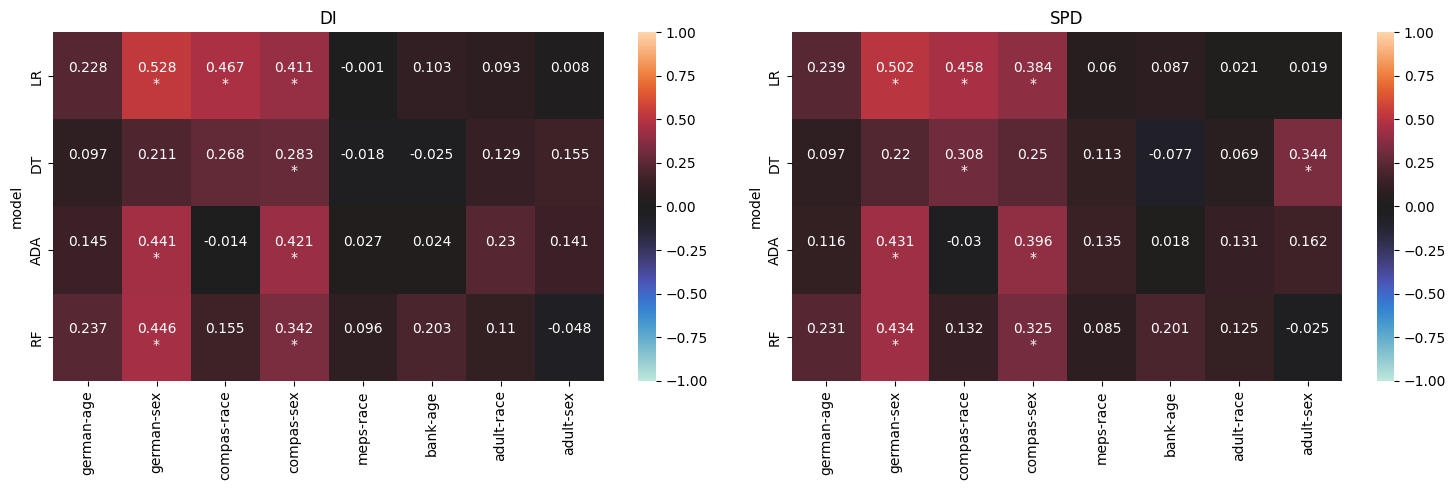

In [18]:
import numpy as np

fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(15, 5)
)

for idx, metric in enumerate(["DI", "SPD"]):
    ax = axs[idx]
    ax.set_title(metric)
    _ = corr.loc[(metric)].astype(float)
    _corr = _.round(3).astype(str)
    _sig = corr_pvalues.loc[(metric)].applymap(
        # lambda x: ''.join(['*' for t in [0.01, 0.05, 0.1] if x<=t])
        lambda x: ''.join(['*' for t in [0.05] if x<=t])
    )
    annot = _corr + "\n" + _sig
    sns.heatmap(
        data=_,
        annot=annot,
        fmt="",
        vmin=-1.,
        vmax=1.,
        center=0.,
        ax=ax,
    )

fig.tight_layout()

# name = "heatmap--corr--training-sets-frac.pdf"
# fig.savefig(os.path.join(REPORTDIR, name), format="pdf")

# name = "heatmap--corr--training-sets-frac.png"
# fig.savefig(os.path.join(REPORTDIR, name), format="png")